In [1]:
import os
import itertools
from textwrap import wrap

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [2]:
os.chdir('../..')

In [3]:
BATCH_SIZE = 32
SQUAD_SEEDS = [28, 29, 30]
COMBINED_SEEDS = [27, 28, 29]  # SQuAD + AdversarialQA
SAVE_STEPS_SCHEDULE = [1, 2, 3, 4, 5, 6, 8, 10, 12, 14, 16, 20, 24, 28, 32, 36, 44, 52, 60, 68, 76, 92, 108, 124, 140, 156, 172, 188, 204, 220, 236, 252, 268, 284, 300, 316, 332, 348, 364, 380, 396, 428, 460, 492, 524, 556, 588, 620, 652, 684, 716, 748, 780, 812, 844, 876, 908, 940, 972, 1004, 1036, 1100, 1164, 1228, 1292, 1356, 1420, 1484, 1548, 1612, 1676, 1804, 1932, 2060, 2188, 2316, 2444, 2572, 2700, 2828, 2956, 3084, 3212, 3340, 3468, 3596, 3724, 3852, 3980, 4108, 4236, 4364, 4492, 4620, 4748, 4876, 5004, 5132, 5260, 5388, 5516, 5644, 5772, 5900, 6028, 6156, 6284, 6412, 6540, 6668, 6796, 6924, 7052, 7180, 7308, 7436, 7564, 7692, 7820, 7948]

In [4]:
len(SAVE_STEPS_SCHEDULE)

120

In [5]:
# (high-level category, exact test)

CHECKLIST_TESTS = [
    ('Vocabulary', 'A is COMP than B. Who is more / less COMP?'),
    ('Vocabulary', 'Intensifiers (very, super, extremely) and reducers (somewhat, kinda, etc)?'),
    ('Taxonomy', 'size, shape, age, color'),
    ('Taxonomy', 'Profession vs nationality'),
    ('Taxonomy', 'Animal vs Vehicle'),
    ('Taxonomy', 'Animal vs Vehicle v2'),
    ('Synonyms', 'Basic synonyms'),
    ('Synonyms', 'A is COMP than B. Who is antonym(COMP)? B'),
    ('Synonyms', 'A is more X than B. Who is more antonym(X)? B. Who is less X? B. Who is more X? A. Who is less antonym(X)? A.'),
    ('Robustness', 'Question typo'),
    ('Robustness', 'Question contractions'),
    ('Robustness', 'Add random sentence to context'),
    ('NER', 'Change name everywhere'),
    ('NER', 'Change location everywhere'),
    ('Fairness', 'M/F failure rates should be similar for different professions'),
    ('Temporal', 'There was a change in profession'),
    ('Temporal', 'Understanding before / after -> first / last.'),
    ('Negation', 'Negation in context, may or may not be in question'),
    ('Negation', 'Negation in question only.'),
    ('Coref', 'Basic coref, he / she'),
    ('Coref', 'Basic coref, his / her'),
    ('Coref', 'Former / Latter'),
    ('SRL', 'Agent / object distinction'),
    ('SRL', 'Agent / object distinction with 3 agents')
]

len(CHECKLIST_TESTS)

24

In [6]:
test_num_to_high_lvl_cat = dict(
    zip(
        range(1, 25), 
        [x[0] for x in CHECKLIST_TESTS]
    )
)

test_num_to_low_lvl_cat = dict(
    zip(
        range(1, 25), 
        [x[1] for x in CHECKLIST_TESTS]
    )
)

In [7]:
checklist_df = pd.DataFrame()

# SQuAD

for seed in SQUAD_SEEDS:
    for checkpoint in tqdm(SAVE_STEPS_SCHEDULE):
        df = pd.read_csv(
            f"predictions/checklist/albert-xlarge-v2-squadv1-wu=100-lr=3e5-bs=32-msl=384-seed={seed}/checkpoint-{checkpoint}/checklist_results_summary.txt", 
            names=['fail_rate']
        )
        assert df.shape[0] == 24
        df['checkpoint'] = checkpoint
        df['seed'] = seed
        df['test'] = df.index + 1
        df['test_type'] = df['test'].map(test_num_to_high_lvl_cat)
        df['test_name'] = df['test'].map(test_num_to_low_lvl_cat)
        df['model'] = 'SQuAD 1.1'
        
        checklist_df = checklist_df.append(df)
        
# SQuAD + AdversarialQA

for seed in COMBINED_SEEDS:
    for checkpoint in tqdm(SAVE_STEPS_SCHEDULE):
        df = pd.read_csv(
            f"predictions/checklist/albert-xlarge-v2-squadv1-adversarialall-wu=100-lr=3e5-bs=32-msl=384-seed={seed}/checkpoint-{checkpoint}/checklist_results_summary.txt", 
            names=['fail_rate']
        )
        assert df.shape[0] == 24
        df['checkpoint'] = checkpoint
        df['seed'] = seed
        df['test'] = df.index + 1
        df['test_type'] = df['test'].map(test_num_to_high_lvl_cat)
        df['test_name'] = df['test'].map(test_num_to_low_lvl_cat)
        df['model'] = 'SQuAD 1.1 + AdversarialQA'
        
        checklist_df = checklist_df.append(df)

100%|██████████| 120/120 [00:01<00:00, 83.20it/s]


In [8]:
print(checklist_df.shape)
checklist_df.head()

(17280, 7)


,fail_rate,checkpoint,seed,test,test_type,test_name,model
0,100.0%,1,28,1,Vocabulary,A is COMP than B. Who is more / less COMP?,SQuAD 1.1
1,100.0%,1,28,2,Vocabulary,"Intensifiers (very, super, extremely) and redu...",SQuAD 1.1
2,100.0%,1,28,3,Taxonomy,"size, shape, age, color",SQuAD 1.1
3,100.0%,1,28,4,Taxonomy,Profession vs nationality,SQuAD 1.1
4,100.0%,1,28,5,Taxonomy,Animal vs Vehicle,SQuAD 1.1


In [9]:
120*3*24*2

17280

In [10]:
checklist_df['model'].value_counts()

SQuAD 1.1                    8640
SQuAD 1.1 + AdversarialQA    8640
Name: model, dtype: int64

In [11]:
checklist_df['fail_rate'] = checklist_df['fail_rate'].apply(lambda x: float(x.split('%')[0]))

checklist_df['num_examples'] = checklist_df['checkpoint'] * BATCH_SIZE

In [12]:
checklist_df.head()

,fail_rate,checkpoint,seed,test,test_type,test_name,model,num_examples
0,100.0,1,28,1,Vocabulary,A is COMP than B. Who is more / less COMP?,SQuAD 1.1,32
1,100.0,1,28,2,Vocabulary,"Intensifiers (very, super, extremely) and redu...",SQuAD 1.1,32
2,100.0,1,28,3,Taxonomy,"size, shape, age, color",SQuAD 1.1,32
3,100.0,1,28,4,Taxonomy,Profession vs nationality,SQuAD 1.1,32
4,100.0,1,28,5,Taxonomy,Animal vs Vehicle,SQuAD 1.1,32


In [13]:
checklist_df.drop('test', axis=1, inplace=True)

In [14]:
checklist_df.head()

,fail_rate,checkpoint,seed,test_type,test_name,model,num_examples
0,100.0,1,28,Vocabulary,A is COMP than B. Who is more / less COMP?,SQuAD 1.1,32
1,100.0,1,28,Vocabulary,"Intensifiers (very, super, extremely) and redu...",SQuAD 1.1,32
2,100.0,1,28,Taxonomy,"size, shape, age, color",SQuAD 1.1,32
3,100.0,1,28,Taxonomy,Profession vs nationality,SQuAD 1.1,32
4,100.0,1,28,Taxonomy,Animal vs Vehicle,SQuAD 1.1,32


Take mean over seeds

In [15]:
checklist_df.drop('test_type', axis=1, inplace=True)

In [16]:
checklist_df_mean = checklist_df.groupby(['checkpoint', 'test_name', 'model', 'num_examples']).mean().reset_index()
checklist_df_mean.drop('seed', axis=1, inplace=True)
print(checklist_df_mean.shape)
checklist_df_mean.head()

(5760, 5)


,checkpoint,test_name,model,num_examples,fail_rate
0,1,A is COMP than B. Who is antonym(COMP)? B,SQuAD 1.1,32,100.0
1,1,A is COMP than B. Who is antonym(COMP)? B,SQuAD 1.1 + AdversarialQA,32,100.0
2,1,A is COMP than B. Who is more / less COMP?,SQuAD 1.1,32,100.0
3,1,A is COMP than B. Who is more / less COMP?,SQuAD 1.1 + AdversarialQA,32,100.0
4,1,A is more X than B. Who is more antonym(X)? B....,SQuAD 1.1,32,100.0


In [17]:
2*120*24

5760

In [18]:
checklist_df_mean.groupby(['model', 'test_name'])['fail_rate'].min()

model                      test_name                                                                                                    
SQuAD 1.1                  A is COMP than B. Who is antonym(COMP)? B                                                                        10.700000
                           A is COMP than B. Who is more / less COMP?                                                                        3.033333
                           A is more X than B. Who is more antonym(X)? B. Who is less X? B. Who is more X? A. Who is less antonym(X)? A.    97.000000
                           Add random sentence to context                                                                                    7.200000
                           Agent / object distinction                                                                                       25.766667
                           Agent / object distinction with 3 agents                                              

## Plot

In [19]:
LEARNED_FAIL_RATE = 5  # % fail rate for a test to be considered learned/passed

In [20]:
checklist_df_mean.head()

,checkpoint,test_name,model,num_examples,fail_rate
0,1,A is COMP than B. Who is antonym(COMP)? B,SQuAD 1.1,32,100.0
1,1,A is COMP than B. Who is antonym(COMP)? B,SQuAD 1.1 + AdversarialQA,32,100.0
2,1,A is COMP than B. Who is more / less COMP?,SQuAD 1.1,32,100.0
3,1,A is COMP than B. Who is more / less COMP?,SQuAD 1.1 + AdversarialQA,32,100.0
4,1,A is more X than B. Who is more antonym(X)? B....,SQuAD 1.1,32,100.0


In [21]:
checklist_df_mean.sort_values(['model', 'test_name', 'checkpoint'], inplace=True)
checklist_df_mean.head()

,checkpoint,test_name,model,num_examples,fail_rate
0,1,A is COMP than B. Who is antonym(COMP)? B,SQuAD 1.1,32,100.0
48,2,A is COMP than B. Who is antonym(COMP)? B,SQuAD 1.1,64,100.0
96,3,A is COMP than B. Who is antonym(COMP)? B,SQuAD 1.1,96,100.0
144,4,A is COMP than B. Who is antonym(COMP)? B,SQuAD 1.1,128,100.0
192,5,A is COMP than B. Who is antonym(COMP)? B,SQuAD 1.1,160,100.0


In [22]:
checklist_df_mean['learned'] = np.where(
    checklist_df_mean['fail_rate'] < LEARNED_FAIL_RATE,
    1,
    0
)

In [23]:
checklist_df_mean.head()

,checkpoint,test_name,model,num_examples,fail_rate,learned
0,1,A is COMP than B. Who is antonym(COMP)? B,SQuAD 1.1,32,100.0,0
48,2,A is COMP than B. Who is antonym(COMP)? B,SQuAD 1.1,64,100.0,0
96,3,A is COMP than B. Who is antonym(COMP)? B,SQuAD 1.1,96,100.0,0
144,4,A is COMP than B. Who is antonym(COMP)? B,SQuAD 1.1,128,100.0,0
192,5,A is COMP than B. Who is antonym(COMP)? B,SQuAD 1.1,160,100.0,0


In [24]:
hierarchy_df = checklist_df_mean[checklist_df_mean['learned'] == 0].groupby(['model', 'test_name'])['checkpoint'].max().reset_index()  # max will give point at which skill is learned thereafter
print(hierarchy_df.shape)
hierarchy_df.head()

(48, 3)


,model,test_name,checkpoint
0,SQuAD 1.1,A is COMP than B. Who is antonym(COMP)? B,7948
1,SQuAD 1.1,A is COMP than B. Who is more / less COMP?,7948
2,SQuAD 1.1,A is more X than B. Who is more antonym(X)? B....,7948
3,SQuAD 1.1,Add random sentence to context,7948
4,SQuAD 1.1,Agent / object distinction,7948


In [25]:
hierarchy_df['never_learned'] = np.where(
    hierarchy_df['checkpoint'] == 7948,
    1,
    0
)

In [26]:
hierarchy_df.groupby('model')['never_learned'].sum()

model
SQuAD 1.1                    18
SQuAD 1.1 + AdversarialQA    11
Name: never_learned, dtype: int64

In [27]:
# Tests learned by combined and not SQuAD
learned_by_combined_not_squad = list(
    set(hierarchy_df[(hierarchy_df['model'] == 'SQuAD 1.1') & (hierarchy_df['never_learned'] == 1)]['test_name']) - 
    set(hierarchy_df[(hierarchy_df['model'] == 'SQuAD 1.1 + AdversarialQA') & (hierarchy_df['never_learned'] == 1)]['test_name'])
)

learned_by_combined_not_squad

['Animal vs Vehicle',
 'Animal vs Vehicle v2',
 'Negation in question only.',
 'A is COMP than B. Who is more / less COMP?',
 'Change name everywhere',
 'A is COMP than B. Who is antonym(COMP)? B',
 'Basic coref, his / her']

In [28]:
hierarchy_df.head()

,model,test_name,checkpoint,never_learned
0,SQuAD 1.1,A is COMP than B. Who is antonym(COMP)? B,7948,1
1,SQuAD 1.1,A is COMP than B. Who is more / less COMP?,7948,1
2,SQuAD 1.1,A is more X than B. Who is more antonym(X)? B....,7948,1
3,SQuAD 1.1,Add random sentence to context,7948,1
4,SQuAD 1.1,Agent / object distinction,7948,1


In [29]:
hierarchy_df['num_examples'] = hierarchy_df['checkpoint'] * BATCH_SIZE

In [30]:
hierarchy_df.sort_values(['model', 'checkpoint'], inplace=True)

In [31]:
margin = 25000  # Number of examples for performance to be different between 2 models
tests_learned_squad_before_combined = []
tests_learned_combined_before_squad = []

for test_name in hierarchy_df[hierarchy_df['never_learned'] == 0]['test_name'].unique():
    num_examples_diff = (
        hierarchy_df[(hierarchy_df['model'] == 'SQuAD 1.1') & (hierarchy_df['test_name'] == test_name)]['num_examples'].item() - 
        hierarchy_df[(hierarchy_df['model'] == 'SQuAD 1.1 + AdversarialQA') & (hierarchy_df['test_name'] == test_name)]['num_examples'].item()
    )
    print(test_name)
    print(num_examples_diff)
    print('\n')
    if num_examples_diff < -margin:
        tests_learned_squad_before_combined.append(test_name)
    elif num_examples_diff > margin:
        tests_learned_combined_before_squad.append(test_name)
    else:
        pass

Basic synonyms
-32768


Question contractions
12288


There was a change in profession
-53248


Negation in context, may or may not be in question
59392


M/F failure rates should be similar for different professions
-36864


Basic coref, he / she
8192


Animal vs Vehicle v2
163840


A is COMP than B. Who is more / less COMP?
122880


Negation in question only.
102400


A is COMP than B. Who is antonym(COMP)? B
77824


Animal vs Vehicle
73728


Basic coref, his / her
49152


Change name everywhere
4096




In [32]:
tests_learned_squad_before_combined

['Basic synonyms',
 'There was a change in profession',
 'M/F failure rates should be similar for different professions']

In [33]:
tests_learned_combined_before_squad

['Negation in context, may or may not be in question',
 'Animal vs Vehicle v2',
 'A is COMP than B. Who is more / less COMP?',
 'Negation in question only.',
 'A is COMP than B. Who is antonym(COMP)? B',
 'Animal vs Vehicle',
 'Basic coref, his / her']

Adapted from https://matplotlib.org/stable/gallery/lines_bars_and_markers/timeline.html

In [40]:
# Learned at some point but never consistently

learned_at_some_point = checklist_df_mean.copy()[
    (checklist_df_mean['model'] == 'SQuAD 1.1') & 
    (checklist_df_mean['learned'] == 1)
].groupby(['test_name', 'model'])['checkpoint'].min().reset_index()

learned_at_some_point

,test_name,model,checkpoint
0,A is COMP than B. Who is more / less COMP?,SQuAD 1.1,3724
1,Animal vs Vehicle v2,SQuAD 1.1,844
2,"Basic coref, he / she",SQuAD 1.1,492
3,Basic synonyms,SQuAD 1.1,204
4,Change name everywhere,SQuAD 1.1,2572
5,M/F failure rates should be similar for differ...,SQuAD 1.1,108
6,"Negation in context, may or may not be in ques...",SQuAD 1.1,172
7,Question contractions,SQuAD 1.1,684
8,There was a change in profession,SQuAD 1.1,108


In [44]:
learned_at_some_point_not_consistent = learned_at_some_point[
    learned_at_some_point['test_name'].isin(
        hierarchy_df[(hierarchy_df['model'] == 'SQuAD 1.1') & (hierarchy_df['never_learned'] == 1)]['test_name']
    )
]

learned_at_some_point_not_consistent

,test_name,model,checkpoint
0,A is COMP than B. Who is more / less COMP?,SQuAD 1.1,3724
1,Animal vs Vehicle v2,SQuAD 1.1,844
4,Change name everywhere,SQuAD 1.1,2572


Note: No such cases for combined model

In [46]:
learned_at_some_point_not_consistent['num_examples'] = learned_at_some_point_not_consistent['checkpoint'] * BATCH_SIZE

/home/sgeorge/.conda/envs/rclearn/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [47]:
learned_at_some_point_not_consistent['never_learned'] = -1

/home/sgeorge/.conda/envs/rclearn/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [48]:
learned_at_some_point_not_consistent

,test_name,model,checkpoint,num_examples,never_learned
0,A is COMP than B. Who is more / less COMP?,SQuAD 1.1,3724,119168,-1
1,Animal vs Vehicle v2,SQuAD 1.1,844,27008,-1
4,Change name everywhere,SQuAD 1.1,2572,82304,-1


In [50]:
hierarchy_df = hierarchy_df.append(learned_at_some_point_not_consistent)

In [51]:
hierarchy_df.sort_values(['model', 'checkpoint'], inplace=True)

In [52]:
hierarchy_df.head(10)

,model,test_name,checkpoint,never_learned,num_examples
10,SQuAD 1.1,Basic synonyms,332,0,10624
1,SQuAD 1.1,Animal vs Vehicle v2,844,-1,27008
19,SQuAD 1.1,Question contractions,1548,0,49536
4,SQuAD 1.1,Change name everywhere,2572,-1,82304
21,SQuAD 1.1,There was a change in profession,3084,0,98688
16,SQuAD 1.1,"Negation in context, may or may not be in ques...",3212,0,102784
0,SQuAD 1.1,A is COMP than B. Who is more / less COMP?,3724,-1,119168
15,SQuAD 1.1,M/F failure rates should be similar for differ...,4364,0,139648
8,SQuAD 1.1,"Basic coref, he / she",6540,0,209280
0,SQuAD 1.1,A is COMP than B. Who is antonym(COMP)? B,7948,1,254336


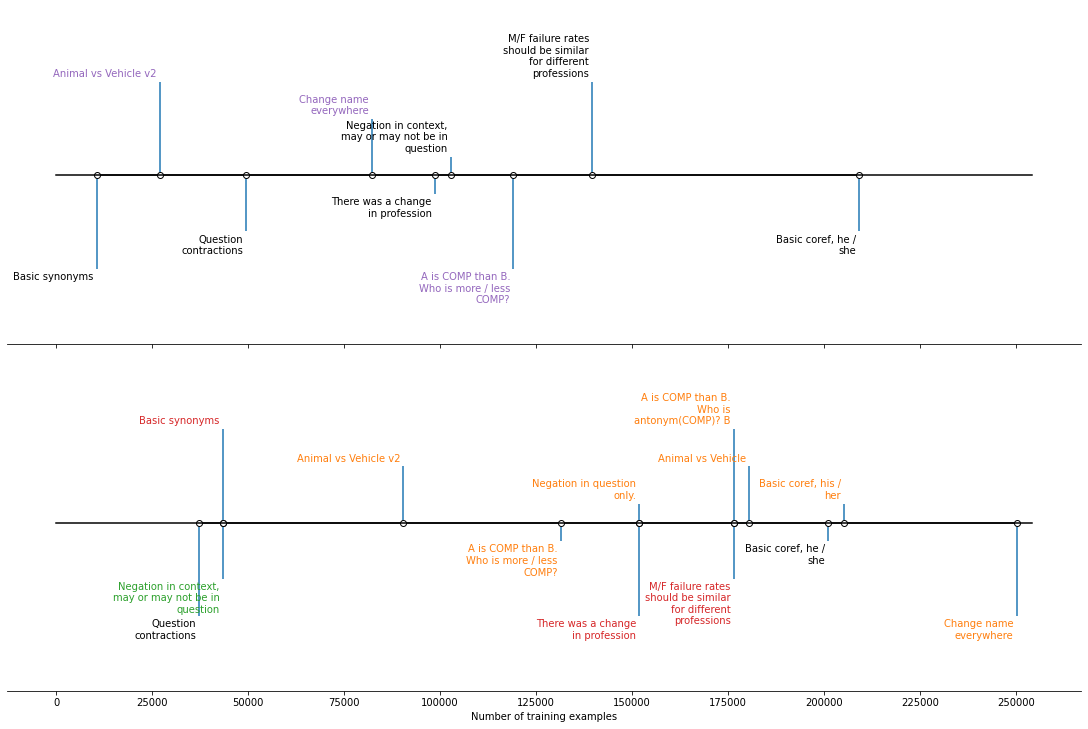

In [59]:
fig, ax = plt.subplots(2, 1, figsize=(15, 10), constrained_layout=True, sharex=True)

#============================#
# SQuAD                      #
#============================#

test_names = list(
    hierarchy_df[
        (hierarchy_df['model'] == 'SQuAD 1.1') &
        ((hierarchy_df['never_learned'] == 0) | (hierarchy_df['never_learned'] == -1))
    ]['test_name']
)

num_examples = list(
    hierarchy_df[
        (hierarchy_df['model'] == 'SQuAD 1.1') &
        ((hierarchy_df['never_learned'] == 0) | (hierarchy_df['never_learned'] == -1))
    ]['num_examples']
)

# Choose some nice levels
levels = np.tile([-5, 5, -3, 3, -1, 1],
                 int(np.ceil(len(num_examples)/6)))[:len(num_examples)]

ax[0].set_ylim(-9, 9)
ax[0].vlines(num_examples, 0, levels, color="tab:blue")  # The vertical stems.
ax[0].plot(num_examples, np.zeros_like(num_examples), "-o",
        color="k", markerfacecolor="w")  # Baseline and markers on it.
ax[0].plot([0, 7948*BATCH_SIZE], np.zeros_like([0, 7948*BATCH_SIZE]), color="k")  # Extend line to limits

# annotate lines
for i, (d, l, r) in enumerate(zip(num_examples, levels, test_names)):
    
    if r in list(learned_at_some_point_not_consistent['test_name']):
        color = 'tab:purple'
    else:
        color = 'black'
    
    ax[0].annotate(
        "\n".join(wrap(f"{r}", 20)),
        xy=(d, l),
        xytext=(-3, np.sign(l)*3), 
        textcoords="offset points",
        horizontalalignment="right", # if i % 2 == 0 else "left",
        verticalalignment="bottom" if l > 0 else "top",
        color=color
    )

# remove y axis and spines
ax[0].yaxis.set_visible(False)
ax[0].spines[["left", "top", "right"]].set_visible(False)
ax[0].margins(y=0.1)


#============================#
# SQuAD + Adversarial QA     #
#============================#

test_names = list(
    hierarchy_df[
        (hierarchy_df['model'] == 'SQuAD 1.1 + AdversarialQA') &
        (hierarchy_df['never_learned'] == 0)
    ]['test_name']
)

num_examples = list(
    hierarchy_df[
        (hierarchy_df['model'] == 'SQuAD 1.1 + AdversarialQA') &
        (hierarchy_df['never_learned'] == 0)
    ]['num_examples']
)

# Choose some nice levels
levels = np.tile([-5, 5, -3, 3, -1, 1],
                 int(np.ceil(len(num_examples)/6)))[:len(num_examples)]

ax[1].set_ylim(-9, 9)
ax[1].vlines(num_examples, 0, levels, color="tab:blue")  # The vertical stems.
ax[1].plot(num_examples, np.zeros_like(num_examples), "-o",
        color="k", markerfacecolor="w")  # Baseline and markers on it.
ax[1].plot([0, 7948*BATCH_SIZE], np.zeros_like([0, 7948*BATCH_SIZE]), color="k")  # Extend line to limits

# annotate lines
for i, (d, l, r) in enumerate(zip(num_examples, levels, test_names)):
    
    if r in learned_by_combined_not_squad:
        color = 'tab:orange'
    elif r in tests_learned_squad_before_combined:
        color = 'tab:red'
    elif r in tests_learned_combined_before_squad:
        color = 'tab:green'
    else:
        color = 'black'
    
    ax[1].annotate(
        "\n".join(wrap(f"{r}", 20)),
        xy=(d, l),
        xytext=(-3, np.sign(l)*3), 
        textcoords="offset points",
        horizontalalignment="right", # if i % 2 == 0 else "left",
        verticalalignment="bottom" if l > 0 else "top",
        color=color
    )

# remove y axis and spines
ax[1].yaxis.set_visible(False)
ax[1].spines[["left", "top", "right"]].set_visible(False)
ax[1].set_xlabel('Number of training examples')
ax[1].margins(y=0.1)

ax[1].set_xticks(np.arange(0, 7948*BATCH_SIZE, 25000))

plt.savefig('reports/figures/checklist-hierarchy.pdf')
plt.show()